# Лабораторная работа по курсу "Глубокое обучение"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import os
import gzip
import time

## Считывание данных

В данной работе используется набор данных MNIST. Данный набор был предварительно скачен с сайта [http://yann.lecun.com/exdb/mnist]. 

- train-images-idx3-ubyte.gz; train-labels-idx1-ubyte – обучающие данные и их метки. 
 - t10k-images-idx3-ubyte, t10k-labels-idx1-ubyte – тестовые данные и их метки. 

In [2]:
# функция, возвращающая разархивирующий файл с картинками 
def readBinFileMatrix(nameFile):
    pathFiles = os.getcwd()
    with gzip.open(pathFiles + '/' +  nameFile,'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, nrows, ncols))
    return np.array(data)

# функция, возвращающая разархивирующий файл с метками 
def readBinFileLabel(nameFile):
    pathFiles = os.getcwd()
    with gzip.open(pathFiles + '/' +  nameFile,'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size,)) 
    return np.array(data)

# функция, возвращающая тренировочные и тестовые данные
def loadData(nameData):
    # nameFile = ['t10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte', 'train-images.idx3-ubyte', 'train-labels.idx1-ubyte']
    if nameData == 'Xtrain':
        return readBinFileMatrix('train-images-idx3-ubyte.gz')
    if nameData == 'Ytrain':
        return readBinFileLabel('train-labels-idx1-ubyte.gz')
    if nameData == 'Xtest':
        return readBinFileMatrix('t10k-images-idx3-ubyte.gz')
    if nameData == 'Ytest':
        return readBinFileLabel('t10k-labels-idx1-ubyte.gz')  

Загрузим тренировочные и тестовые данные. Выведем на экран размерность данных.

In [3]:
train_x = loadData('Xtrain')
train_y= loadData('Ytrain')
print('Shape X_train = {}, Shape y_train = {}'.format(train_x.shape, train_y.shape))

test_x = loadData('Xtest')
test_y = loadData('Ytest')
print('Shape X_test = {}, Shape y_test = {}'.format(test_x.shape, test_y.shape))

Shape X_train = (60000, 28, 28), Shape y_train = (60000,)
Shape X_test = (10000, 28, 28), Shape y_test = (10000,)


Проверм, что данные считались корректно. Для этого выведем на экран первую цифру и её метку класса.

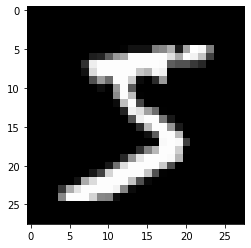

Label: 5


In [4]:
plt.imshow(train_x[0,:,:], cmap='gray')
plt.show()
print('Label: {}'.format(train_y[0]))

## Нормировка данных

In [5]:
train_x = train_x.reshape(
    train_x.shape[0], train_x.shape[1]*train_x.shape[2]).astype('float32')
train_x = train_x / 255 
train_y = np.eye(10)[train_y] 
print('Shape X_train = {}, Shape y_train = {}'.format(train_x.shape, train_y.shape))

# flatten 28x28 to 784x1 vectors, [60000, 784]
test_x = test_x.reshape(
    test_x.shape[0], test_x.shape[1]*test_x.shape[2]).astype('float32')
test_x = test_x / 255 
test_y = np.eye(10)[test_y]
print('Shape X_test = {}, Shape y_test = {}'.format(test_x.shape, test_y.shape))

Shape X_train = (60000, 784), Shape y_train = (60000, 10)
Shape X_test = (10000, 784), Shape y_test = (10000, 10)


## Математическая модель

Рассмотрим двухслойную нейронную сеть

[![2022-12-15_20-15-21.md.png](https://ic.wampi.ru/2022/12/18/2022-12-15_20-15-21.md.png)](https://wampi.ru/image/RHEMg2t)

где 
- $ \ x_i$ - множество входных сигналов 
- $ \ u_j$ - выход сети
- $ \ v_s$ - выходной сигнал нейрона скрытого слоя
- $ \ w_{si}^{(1)} $ и $ \ w_{js}^{(2)} $ - веса синаптических связей

Модель нейрона описывается следующими уравнениями:

$$ \ u_k=\sum_{j=1}^{n}w_{k,j}x_j$$

$$ \ y_k=\varphi(u_k+b_k)$$

где 
$\ x_j$ - входной сигнал, $\ w_{k,j} $ - синаптический вес сигнала $\ x_j$, $\ \varphi $ - функция активации, $\ b_k$ - смещение.

Метод обратного распространения ошибки определяет
стратегию изменения параметров сети $\ 𝑤 $ в ходе обучения
с использованием градиентных методов оптимизации.

Градиентные методы на каждом шаге уточняют значения параметров: $\ w(k+1) = w(k) + \eta p(w)$

где
- $ \ \eta $ , $ \ 0 < \eta < 1 $ – скорость обучения (learning rate) –«скорость» движения в направлении минимального значения функции
- $ \ 𝑝(𝑤) $ – направление в многомерном пространстве параметров нейронной сети


В классическом методе обратного распространения ошибки направление движения совпадает с направлением антиградиента $ \ 𝑝(𝑤) = −\nabla 𝐸(𝑤(𝑘)) $ на 𝑘-ой итерации метода.

### Метод обратного распространения ошибки

#### 1. Прямой проход

1. Вычисление значений выходных сигналов нейронов всех слоев
2. Вычисление значений производных функций активации на каждом
слое сети

Выходной сигнал нейрона скрытого слоя описывается следующим образом:

$$ \ v_s = \varphi ^{(1)} (\sum_{i=1}^{N}w_{si}^{(1)}x_i) $$

Сигнал 𝑗-ого нейрона выходного слоя:

$$ \ u_j = \varphi ^{(2)}(\sum_{s=0}^{K}w_{js}^{(2)}v_s) = \varphi ^{(2)}(\sum_{s=0}^{K}w_{js}^{(2)}\varphi ^{(1)} (\sum_{i=0}^{N}w_{si}^{(1)}x_i)), \ j = 1,M $$ 

В качестве функции активации на скрытом слое используется ReLU (Rectified Linear Unit).

$$ \ \varphi(v) = \begin{cases} 0,v \leq 0 \\ v,v>0 \end{cases}$$

[![2022-12-18_11-51-48.png](https://im.wampi.ru/2022/12/18/2022-12-18_11-51-48.png)](https://wampi.ru/image/RHEMDAg)

Её производная есть 

$$ \ \varphi(v)^{'} = \begin{cases} 0,v \leq 0 \\ 1,v>0 \end{cases}$$

В качестве функции активациии на выходном слое используется функция softmax.

$$\ \varphi(u_j) = \frac{e^{u_j} }{\sum_{i=1}^{M} e^{u_i}} $$

#### 2. Обратный проход

1. Вычисление целевой функции 𝐸 и ее градиента  $\ \frac{\partial E }{\partial w_{js}^{(2)}} $ и $\ \frac{\partial E }{\partial w_{si}^{(1)}}$ 
2. Коррекция весов $\ 𝑤(𝑘 + 1) = 𝑤(𝑘) − \eta \nabla 𝐸(𝑤(𝑘)) $

В качестве функции ошибки используется кросс-энтропия (или логарифмическая функция потерь – log loss), т.е. 

$$\ E(w) = - \sum_{j=1}^{M}y_j ln(u_j) $$

где $\ y_j$ ожидаемый выход (метки).

Производную целевой функции по весам можно вывести следующим образом:

По весам второго слоя:

$$\ \frac{\partial E }{\partial w_{js}^{(2)}} = - \sum_{j'=0}^{M} y_{j'} \frac{\partial \ln u_{j'}}{\partial w_{js}^{(2)}} =   - \sum_{j'=0}^{M} y_{j'} \frac{1}{u_{j'}} \frac{\partial u_{j'}}{\partial w_{js}^{(2)}}$$

$$ \ \frac{\partial u_{j'}}{\partial w_{js}^{(2)}} = \frac{\partial \varphi ^{(2)} (g_{j'})}{\partial g_{j}} \frac{\partial g_{j}}{\partial w_{js}^{(2)}} = \varphi (g_{j'}) (\delta_{j,j'}-\varphi(g_i)) \frac{\partial g_j}{\partial w_{js}^{(2)}}$$

$$ \ g_j = \sum_{s=0}^K w_{ij}^{(2)}v_s;  \frac{\partial g_j}{\partial w_{js}^{(2)}} = v_s$$

$$\ \frac{\partial E }{\partial w_{js}^{(2)}} = - \sum_{j'=0}^{M} y_{j'} (\delta_{j,j'}-\varphi^{(2)}(g_i))v_s = (\varphi^{(2)}(g_j) \sum_{j'=0}^{M} y_{j'} - y_i )v_s $$

из условия $ \ \sum_{j=1}^M y_j = 1$ получаем

$$\ \frac{\partial E }{\partial w_{js}^{(2)}} = (\partial^{(2)}(g_j) - y_j)v_s $$

По весам первого слоя

$$\ \frac{\partial E }{\partial w_{si}^{(1)}} = - \sum_{j'=0}^{M} y_{j'} \frac{\partial \ln u_{j'}}{\partial w_{si}^{(1)}} = - \sum_{j'=0}^{M} y_{j'}  \frac{1}{u_{j'}} \frac{\partial u_{j'}}{\partial w_{si}^{(1)}}$$

$$ \ \frac{\partial u_{j'}}{\partial w_{si}^{(1)}} = \frac{\partial \varphi ^{(2)} (g_{j'})}{\partial g_{j}} \frac{\partial g_{j}}{\partial w_{si}^{(1)}} = \varphi^{(2)} (g_{j'}) (\delta_{j',j}-\varphi^{(2)}(g_i)) w_{js}^{(2)} \frac{\partial \varphi_i^{(1)}}{\partial w_{si}^{(1)}}x_i$$

$$\ \frac{\partial E }{\partial w_{si}^{(1)}} = (\sum_{j'=0}^M (y_{j'}-u_{j'})w_{j's}^{(2)})\frac{\partial \varphi_i^{(1)}}{\partial w_{si}^{(1)}}x_i $$

##  Программная реализация

In [6]:
# определение функции активации ReLU на скрытом слое
def ReLU(x):
    return np.maximum(x, 0)

# определение производной функции автивации ReLU
def ReLuDerivative(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

# определение функции активации softmax на выходном слое
def softmax(x):
    exp = np.exp(x)
    return exp / np.sum(exp, axis = 1, keepdims = True)

# определение функции ошибки кросс-энтропия
def crossEntropyLoss(x1, x2):
    return np.mean(-np.sum(x1 * np.log(x2), axis=1))

# функция подсчета точности на тестовой или обучающей выборке 
def accuracy(x1, x2):
  return np.mean(np.argmax(x1, axis=1) == np.argmax(x2, axis=1))

Создадим класс NeuralNetwork, который будет содержать имплементацию основных методов нейронной сети

In [11]:
class NeuralNetwork(object):
    # Объявление конструктора
    def __init__(self, input_layer=28 * 28, hidden_layer=300, output_layer=10):
        # инициализация
        # количество нейронов входного слоя 
        self.input_layer = input_layer
        # количество нейронов скрытого слоя
        self.hidden_layer = hidden_layer
        # количество нейронов выходного слоя
        self.output_layer = output_layer
        
        # w1, w2 (веса синаптических связей) инициализируем нормальным распределением с дисперсией sqrt(input_layer)
        # w1 и b1 массивы для хранения весов и смещений первого слоя
        self.w1 = np.random.randn(input_layer, hidden_layer) / np.sqrt(input_layer)
        self.b1 = np.zeros((1, hidden_layer))
        # w2 и b2 массивы для хранения весов и смещений второго слоя
        self.w2 = np.random.randn(hidden_layer, output_layer) / np.sqrt(hidden_layer)
        self.b2 = np.zeros((1, output_layer))
    
    # прямой ход сети
    # Возвращает выходной сигнал первого и второго слоя
    def forward(self, x):
        self.z1 = np.matmul(x, self.w1) + self.b1
        self.a1 = ReLU(self.z1)
        self.z2 = np.matmul(self.a1, self.w2) + self.b2
        self.a2 = softmax(self.z2)

    # обратных ход сети
    # вычисление градиента функции ошибки
    # корректировка весов сети при помощи посчитанных градиентов
    def backward(self, xTrain, yTrain, learningRate):
        w1, b1, w2, b2 = self.w1, self.b1, self.w2, self.b2

        delta3 = (self.a2 - yTrain) / self.a2.shape[0]
        dW2 = (self.a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)

        delta2 = delta3.dot(self.w2.T) * ReLuDerivative(self.z1)
        dW1 = np.dot(xTrain.T, delta2)
        db1 = np.sum(delta2, axis=0, keepdims=True)

        self.w1 += -learningRate * dW1
        self.b1 += -learningRate * db1
        self.w2 += -learningRate * dW2
        self.b2 += -learningRate * db2

    # пакетное обучение сети на epochs эпохах, скоростью обучения l_rate, размером пакета batch_size
    def train(self, X_train, y_train, num_epochs=10, l_rate=0.1, batch_size=16):
        print('Train ...')
        all_time = time.time()
        for epoch in range(num_epochs):
            epoch_time_start = time.time()
            iteration = 0
            while iteration < len(X_train):
                # берем часть данных, размером batch_size
                X_train_batch = X_train[iteration:iteration+batch_size]
                y_train_batch = y_train[iteration:iteration+batch_size]
                
                self.forward(X_train_batch)
                self.backward(X_train_batch, y_train_batch, l_rate)

                iteration += batch_size
            epoch_time = time.time()

            self.forward(X_train)
            crossEntropyValue = crossEntropyLoss(y_train, self.a2)
            accuracyValue = accuracy(y_train, self.a2)

            print('Epoch: {}; Time: {}; Loss: {}; Accuracy: {}'.format(epoch, epoch_time - epoch_time_start, crossEntropyValue, accuracyValue))
        print(f"Total train time: {(time.time()-all_time):.3f} sec")

    # тестирование сети
    # вывод метрик loss и accuracy
    def test(self, X_test, y_test):
        print('Test ...')
        all_time = time.time()
        self.forward(X_test)
        crossEntropyValue = crossEntropyLoss(y_test, self.a2)
        accuracyValue = accuracy(y_test, self.a2)

        print('Loss = {}; Accuracy = {}'.format(crossEntropyValue, accuracyValue))
        print(f"Total test time: {time.time() - all_time} sec")


In [12]:
# Создание объекта разработанного класса
network = NeuralNetwork()

In [13]:
# Обучение модели на 10 эпохах, скоростью обучения 0.1, размером пакета 16
network.train(train_x, train_y, num_epochs=10, l_rate=0.1, batch_size=16)

Train ...
Epoch: 0; Time: 18.00784158706665; Loss: 0.1349527058387903; Accuracy: 0.9576333333333333
Epoch: 1; Time: 16.74522376060486; Loss: 0.08370092845220185; Accuracy: 0.9739
Epoch: 2; Time: 16.751219034194946; Loss: 0.06145281115565548; Accuracy: 0.9806833333333334
Epoch: 3; Time: 16.82201313972473; Loss: 0.04785633851741321; Accuracy: 0.9845166666666667
Epoch: 4; Time: 16.820075750350952; Loss: 0.04104109750956039; Accuracy: 0.9866666666666667
Epoch: 5; Time: 16.89297604560852; Loss: 0.034057166605354766; Accuracy: 0.989
Epoch: 6; Time: 16.794084787368774; Loss: 0.02821324932708801; Accuracy: 0.9910333333333333
Epoch: 7; Time: 17.208982706069946; Loss: 0.02268514669964699; Accuracy: 0.9928
Epoch: 8; Time: 17.462302923202515; Loss: 0.01819413801111785; Accuracy: 0.9944166666666666
Epoch: 9; Time: 60.03344774246216; Loss: 0.01628618454131359; Accuracy: 0.9952833333333333
Total train time: 227.006 sec


In [14]:
# тестирование модели
network.test(test_x, test_y)

Test ...
Loss = 0.0735054455477396; Accuracy = 0.9778
Total test time: 0.17752361297607422 sec


"Поиграемся" с параметрами модели

In [15]:
network = NeuralNetwork()
# Обучение модели на 10 эпохах, скоростью обучения 0.1, размером пакета 64
network.train(train_x, train_y, num_epochs=10, l_rate=0.1, batch_size=64)
network.test(test_x, test_y)

Train ...
Epoch: 0; Time: 5.090388536453247; Loss: 0.24294348513074265; Accuracy: 0.9280666666666667
Epoch: 1; Time: 5.972088098526001; Loss: 0.1715999161383804; Accuracy: 0.9502
Epoch: 2; Time: 5.992071628570557; Loss: 0.13298560913337765; Accuracy: 0.9616666666666667
Epoch: 3; Time: 5.941112518310547; Loss: 0.10770514035803948; Accuracy: 0.9691
Epoch: 4; Time: 5.963052988052368; Loss: 0.08956400645403255; Accuracy: 0.9745166666666667
Epoch: 5; Time: 6.005940914154053; Loss: 0.07586757175581064; Accuracy: 0.9786333333333334
Epoch: 6; Time: 5.945213794708252; Loss: 0.06548302043785972; Accuracy: 0.98185
Epoch: 7; Time: 5.985988616943359; Loss: 0.05745028924880232; Accuracy: 0.9843666666666666
Epoch: 8; Time: 6.00201416015625; Loss: 0.05105409641189437; Accuracy: 0.9864166666666667
Epoch: 9; Time: 5.976008176803589; Loss: 0.04579017932541774; Accuracy: 0.98805
Total train time: 71.740 sec
Test ...
Loss = 0.07396158594576653; Accuracy = 0.9772
Total test time: 0.26427483558654785 sec


In [16]:
network = NeuralNetwork(input_layer=28 * 28, hidden_layer=100, output_layer=10)
# Обучение модели на 10 эпохах, скоростью обучения 0.1, размером пакета 16
network.train(train_x, train_y, num_epochs=10, l_rate=0.1, batch_size=64)
network.test(test_x, test_y)

Train ...
Epoch: 0; Time: 1.059169054031372; Loss: 0.26034218842562806; Accuracy: 0.9227
Epoch: 1; Time: 1.4261975288391113; Loss: 0.18869846939711332; Accuracy: 0.9442
Epoch: 2; Time: 2.0904133319854736; Loss: 0.1485427282522527; Accuracy: 0.9565666666666667
Epoch: 3; Time: 1.3025224208831787; Loss: 0.12263490128501105; Accuracy: 0.9644833333333334
Epoch: 4; Time: 2.1153440475463867; Loss: 0.10480436048740525; Accuracy: 0.9695666666666667
Epoch: 5; Time: 2.0734517574310303; Loss: 0.09198975938093959; Accuracy: 0.9730166666666666
Epoch: 6; Time: 2.1023786067962646; Loss: 0.08204000656390269; Accuracy: 0.9759666666666666
Epoch: 7; Time: 2.1023709774017334; Loss: 0.07364010494164555; Accuracy: 0.9785333333333334
Epoch: 8; Time: 2.06646990776062; Loss: 0.06706364376078995; Accuracy: 0.9800833333333333
Epoch: 9; Time: 2.1642138957977295; Loss: 0.06142786623959192; Accuracy: 0.9818166666666667
Total train time: 25.613 sec
Test ...
Loss = 0.08833317490485565; Accuracy = 0.9733
Total test tim

## Контрольный набор данных

Запустим нашу модель на контрольном наборе параметров: размер пачки 64, скорость обучения составляет 0.1, количество скрытых нейронов – 300, количество эпох – 20.

In [17]:
network = NeuralNetwork(input_layer=28 * 28, hidden_layer=300, output_layer=10)
network.train(train_x, train_y, num_epochs=20, l_rate=0.1, batch_size=64)
network.test(test_x, test_y)

Train ...
Epoch: 0; Time: 4.638623237609863; Loss: 0.2372415223735498; Accuracy: 0.9303333333333333
Epoch: 1; Time: 5.945101499557495; Loss: 0.16535430731543788; Accuracy: 0.95125
Epoch: 2; Time: 6.0797953605651855; Loss: 0.12740871082300592; Accuracy: 0.9631
Epoch: 3; Time: 6.143598318099976; Loss: 0.10327006829697495; Accuracy: 0.9708166666666667
Epoch: 4; Time: 6.080739259719849; Loss: 0.08650579076716439; Accuracy: 0.9756833333333333
Epoch: 5; Time: 6.071762800216675; Loss: 0.07396265731808521; Accuracy: 0.9793833333333334
Epoch: 6; Time: 5.919201374053955; Loss: 0.0645307308825114; Accuracy: 0.9819166666666667
Epoch: 7; Time: 5.920161724090576; Loss: 0.057073297857151636; Accuracy: 0.9843
Epoch: 8; Time: 5.926152944564819; Loss: 0.05108395936046026; Accuracy: 0.9859333333333333
Epoch: 9; Time: 5.907189130783081; Loss: 0.046115866895064916; Accuracy: 0.9874166666666667
Epoch: 10; Time: 6.098692417144775; Loss: 0.042079473095414516; Accuracy: 0.9886166666666667
Epoch: 11; Time: 5.92

## Реализация PyTorch

Проверм, достигнута ли точность классификации на тестовых данных для контрольных значений параметров, сравнимая с точностью, которую выдают стандартные инструменты глубокого обучения. 

Для этого напишем воспользуемся PyTorch. 

In [18]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
from torch import nn
import torch.optim as optim
import os
from matplotlib import pyplot as plot

C:\Users\PC\.conda\envs\deeplean\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
input_size = 28*28
hidden_size = 300
output_size = 10
batch_size = 64
num_epochs = 20
l_rate = 0.1

class TorchNeuralNetwork(nn.Module):
      # Объявление конструктора
      def __init__(self):
            super().__init__()
            self.layer1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.layer2 = nn.Linear(hidden_size, output_size)
            self.softmax = nn.Softmax(dim=0)
    # Переопределение метода, вызываемого в процессе прямого прохода
      def forward(self, x):
            out = self.layer1(x)
            out = self.relu(out)
            out = self.layer2(out)
            out = self.softmax(out)
            return out

# Создание объекта разработанного класса
nn_model = TorchNeuralNetwork()
print(nn_model)

optimizer = optim.SGD(nn_model.parameters(), lr=l_rate)
loss_func = nn.CrossEntropyLoss()


TorchNeuralNetwork(
  (layer1): Linear(in_features=784, out_features=300, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=300, out_features=10, bias=True)
  (softmax): Softmax(dim=0)
)


In [20]:
def train(model, train_x, train_y, loss_func, optimizer, batch_size, num_epochs):
      all_time = time.time()

      for epoch in range(num_epochs):
            epoch_time_start = time.time()
            iteration = 0
            while iteration < len(train_x):
                  X_train_batch = torch.tensor(train_x[iteration:iteration+batch_size])
                  y_train_batch = torch.tensor(train_y[iteration:iteration+batch_size])
                  # Прямой проход
                  net_out = model(X_train_batch) # вычисление выхода сети
                  loss = loss_func(net_out, y_train_batch) # вычисление функции ошибки
                  # Обратный проход
                  optimizer.zero_grad() # обнуление всех вычисляемых градиентов
                  loss.backward() # вычисление градиента функции ошибки
                  optimizer.step() # обновление параметров модели

                  iteration += batch_size
            
            epoch_time = time.time()
 
            accuracy_train = accuracy(model(torch.tensor(train_x)).detach().numpy(), train_y)
            print('Epoch: {}; Time: {}, Loss: {}; Accuracy: {}'.format(epoch, epoch_time - epoch_time_start, loss, accuracy_train))
      print(f"Total train time: {(time.time()-all_time):.3f} sec")

def test(model, test_x, test_y):
      print("Test ...")
      all_time = time.time()
      accuracy_test = accuracy(model(torch.tensor(test_x)).detach().numpy(), test_y)
      print('Accuracy test: {}'.format(accuracy_test))
      print(f"Total test time: {time.time() - all_time} sec")


In [21]:
train(nn_model, train_x, train_y, loss_func, optimizer, 64, 20)

Epoch: 0; Time: 2.380633592605591, Loss: 2.2841494977474213; Accuracy: 0.72665
Epoch: 1; Time: 3.4866771697998047, Loss: 2.147377446293831; Accuracy: 0.7202
Epoch: 2; Time: 3.3979172706604004, Loss: 2.0820818319916725; Accuracy: 0.7411666666666666
Epoch: 3; Time: 3.4019062519073486, Loss: 2.0629787296056747; Accuracy: 0.79005
Epoch: 4; Time: 3.4307913780212402, Loss: 2.0555210188031197; Accuracy: 0.8026333333333333
Epoch: 5; Time: 3.3630142211914062, Loss: 2.0508678443729877; Accuracy: 0.8093
Epoch: 6; Time: 3.3919310569763184, Loss: 2.047722462564707; Accuracy: 0.8133833333333333
Epoch: 7; Time: 3.355032444000244, Loss: 2.0455083772540092; Accuracy: 0.8172833333333334
Epoch: 8; Time: 3.3819503784179688, Loss: 2.043867826461792; Accuracy: 0.8202
Epoch: 9; Time: 3.3580188751220703, Loss: 2.042600031942129; Accuracy: 0.82245
Epoch: 10; Time: 3.3789641857147217, Loss: 2.0416219867765903; Accuracy: 0.8239833333333333
Epoch: 11; Time: 3.3759748935699463, Loss: 2.0408297553658485; Accuracy: 

In [22]:
test(nn_model, train_x, train_y)

Test ...
Accuracy test: 0.8347166666666667
Total test time: 0.3131601810455322 sec
